In [1]:
%pylab inline
from scipy import optimize
from IPython.display import display, Math, Latex
import emcee
import matplotlib.gridspec as gridspec
#import corner
from scipy import stats 

Populating the interactive namespace from numpy and matplotlib


In [2]:
#mass units
M = (10.0**10)/0.7
#vol of illustris run
vol = (75.0/(0.7))**3
print(75./0.7)

# Gives the x,y of the histogram for logmasses from the given array of mass
def histog( mf, nbins ):
    hist, bin_edges = np.histogram(mf, bins = nbins)
    # Obtains the center point for each bin
    xcenter = (bin_edges[:-1] + bin_edges[1:])/2
    return np.array(xcenter), np.array(hist/vol)

# Truncates float to n decimal parts
def truncate(d,n):
    before_dec, after_dec = str(d).split('.')
    d = float('.'.join((before_dec, after_dec[0:n-1])))
    return d

# Schechter function
def Schechter(m,phi_s,alpha,m_s):
    MHI = 10.**m
    M_s = 10.**m_s
    return np.log(10.)*phi_s*((MHI/M_s)**(alpha+1))*numpy.exp(-MHI/M_s)

# loads the file with halo masses and makes the quartiles
# file formated env,mass
# j defines if we treat gass or dm j = 0,1
# j = 0 -> gas
# j = 1 -> dm
# j = 2 -> stars and dust
# j = 3 -> black holes
# j = 4 -> central black hole
# minMass minimum mass allowed to have into account a halo
def loadHaloes(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j])> minMass)]
    mass = M*mtable[j][where(M*mtable[j]> minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1
    global q2
    global q3
    global q4
    global q5
    q5 = M*mtable[j][where(M*mtable[j]> minMass)]

    
    q = np.percentile(lsigma,25)
    # Keeps first quartile
    q1 = mass[where(lsigma <= q)]
    # Removes fist quartile from lsigma
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Second quartile
    q = np.percentile(lsigma,33.333333)
    q2 = mass[where(lsigma <= q)]
    mass = mass[where(lsigma > q)]
    lsigma = lsigma[where(lsigma > q)]
    # Third and Fourth quartile
    q = np.percentile(lsigma,50)
    q3 = mass[where(lsigma <= q)]
    q4 = mass[where(lsigma >= q)]
    
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))

# Loads the file with environment classification T-Web
# file formated env,massgas,masdm
# j defines if we treat gass or dm j = 0,1
# minMass minimum mass allowed to have into account a halo
def loadTweb(name, massname, neigh, j, minMass):
    table = np.loadtxt(name, skiprows = 0, delimiter = ',').T
    mtable = np.loadtxt(massname, skiprows = 0, delimiter  = ',').T
    #table[0] = neigh/(np.pi*table[0]+1e-9)
    print("number of haloes before: " + str(len(table.T)))
    
    # Only take the haloes with not null mass
    lsigma = table[0][where((M*mtable[j]) > minMass)]
    mass = M*mtable[j][where(M*mtable[j] > minMass)]
    
    print("number of haloes after: " + str(len(mass)))

    # Calculates the first quartile of logsigma
    global q1 
    global q2 
    global q3 
    global q4 
    global q5 
    q1 = mass[np.where(lsigma == 3)]
    q2 = mass[np.where(lsigma == 2)]
    q3 = mass[np.where(lsigma == 1)]
    q4 = mass[np.where(lsigma == 0)]
    q5 = mass
    # verify the length of each quartile
    print(len(q1),len(q2),len(q3),len(q4), sum([len(q1),len(q2),len(q3),len(q4)]))
    
def SchtrGraph2(bins,filename,title, boolean, indi):
    # indi is 0 if graphing quartiles, 1 if graphing Tweb
    # Graphics of the mass function for each quartile
    fig, axes = plt.subplots( nrows=4, ncols=2, figsize=(10,15) )
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    gs = gridspec.GridSpec(4,2)
    ax = plt.subplot(gs[0:2,0:])
    ax1 = plt.subplot(gs[2:,0:])
    #ax2 = plt.subplot(gs[1,1])
    #ax0 = plt.subplot(gs[0, 0])
    
    # Plots Total mass function
    '''
    fig, axes = plt.subplots( nrows=2, ncols=1, figsize=(15,20) )
    gs = gridspec.GridSpec(2,1)
    ax0 = plt.subplot(gs[0, 0])
    ax = plt.subplot(gs[1,0])
    tmp = histog(log10(q5),bins+5)
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    ax0.errorbar( tmp[0], log10(tmp[1]),  1./(sqrt(tmp[1]*vol)), fmt='o', ecolor = 'b',
                        c = 'g', markersize=7,elinewidth=1.5)
    '''
    
    # Callable lists
    qs = [q1,q2,q3,q4]
    indx = ['1st quartile','2nd quartile','3rd quartile','4th quartile']
    cs = ['b','g','r','y']
    fmts = ['o','>','<','s']
    alph = []
    dalph = []
    ms = []
    dms = []
    minx = 40
    maxx = -1
    miny = 100
    maxy = -100
    # Chooses normalization factor as first phi_s
    tmp = histog(log10(q1),15)
    #rint(tmp)
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    phi = 1
    if ( boolean ):
        fiiit,sampler = fitMCMC(tmp)
        #print(fiiit)
        ft = fiiit.T[0]
        errors = fiiit.T[1:]
        phi = ft[0]
    ind = 0
    for q,i,co,fm in zip(qs,indx,cs,fmts):
        # Histo for first quartile
        tmp = histog(log10(q),bins)
        tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
        #print tmp
        if ( boolean ):
            logm = linspace(min(tmp[0])-0.3,max(tmp[0])+0.1, 200)
            fiiit,sampler = fitMCMC(tmp)
            #print(fiiit)
            ft = fiiit.T[0]
            errors = fiiit.T[1:].T
            print("......................................................")
            print(ft[0],errors[0])
            print(ft[1],errors[1])
            print(ft[2],errors[2])
            ax.errorbar( tmp[0], log10(tmp[1]*(phi/ft[0]))-ind,  1./(sqrt(tmp[1]*vol)), fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        else: 
            ax.errorbar( tmp[0], log10(tmp[1]),  1./(sqrt(tmp[1]*vol))-ind, fmt=fm, ecolor = co,
                        c = co, markersize=7,elinewidth=1.5)
        # Decimals to show
        if ( boolean ):
            m = 5
            ax.plot(logm, log10(Schechter(logm,ft[0],ft[1],ft[2])*(phi/ft[0])) -ind,co
                 #,label = r"$\alpha$ = " + str(truncate(ft[1],m))+"\n"
                 #+ r"$m_\ast$ = " + str(truncate(ft[2],m))+"\n"  )
                 )
            alph.append(ft[1])
            dalph.append(errors[1])
            ms.append(ft[2])
            dms.append(errors[2])
            #ax.bar( tmp[0] , log10(tmp[1]), width = tmp[0][1]-tmp[0][2], alpha = 0.4, align = 'center' )
            #ax.legend(prop={'size':13})
        #savetxt(name + "q2.csv",(array([tmp[0], tmp[1], sqrt(vol*tmp[1])/(vol*tmp[1])]).T), delimiter = ',')
        #ax.set_title(i, fontsize = 18)
        ax.set_ylabel('$Log_{10}(n)$', fontsize = 20)
        ax.set_xlabel('$Log_{10}(M/M_{\odot})$', fontsize = 20)
        minx = min([minx,min(tmp[0])])
        maxx = max([maxx,max(tmp[0])])
        if ( boolean ):
            miny = min([miny,min(log10(tmp[1]*(phi/ft[0])))-ind])
            maxy = max([maxy,max(log10(tmp[1]*(phi/ft[0])))-ind])
        else:
            miny = min([miny,min(log10(tmp[1]))-ind])
            maxy = max([maxy,max(log10(tmp[1]))-ind])
        ################################################################
        ind += 0.5
    ax.set_title(title,fontsize = 20)
    tmp = histog(log10(q5),bins)
    ax.set_xlim(minx-0.3,maxx+0.3)
    if ( boolean ):
        ax.set_xlim(minx-0.3,maxx+1.5)
    ax.set_ylim(miny-0.3,maxy+0.3)
    #ax.set_ylim(-6.,0.)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ###############################################################################3
    # Plots knee mass and alpha
    ###################################################################################
    labs = []
    if indi:
        labs = ['4th', '3rd', '2nd','1st']
    else: 
        labs = ['Cluster','Sheet','Fillament','Void']
    cs = ['b','g','r','y']
    fmts = ['o','>','<','s']
    for al,dal,ma,dma,fmtt,col,lab in zip(alph,dalph,ms,dms,fmts,cs,labs):
        print(al,dal,ma,dma,fmtt,col,lab)
        ax1.errorbar( np.array([al]), np.array([ma]),xerr=np.array([dal]).T, yerr = np.array([dma]).T
                     , fmt=fmtt, ecolor = 'r', 
                     c = col, markersize=10,elinewidth=1.5,label =lab)
        ax1.legend(prop={'size':13})
    #ax.set_xlim(0.5,4.5)
    d = 0.1
    d2 = 0.1
    ax1.set_xlim(min(alph)-d,max(alph)+d)
    ax1.set_ylim(min(ms)-d2,max(ms)+d2)
    ax1.set_ylabel(r"$Log(m_\ast)$", fontsize = 30)
    ax1.set_xlabel(r"$\alpha$", fontsize = 30)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    #ax.set_title(title, fontsize = 30)
    savefig(filename)
    return array(alph),array(dalph).T,array(ms),array(dms).T

    
def graph(x,dx,d,name,title,filename):
    fig, ax = plt.subplots( nrows=1, ncols=1, figsize=(10,7) )
    q = [1,2,3,4]
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.3)
    ax.errorbar( q, x, yerr = dx, fmt='o', ecolor = 'r', c = 'b', markersize=7,elinewidth=1.5)
    ax.set_xlim(0.5,4.5)
    ax.set_ylim(min(x)-d,max(x)+d)
    ax.set_ylabel(name, fontsize = 30)
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    ax.set_xlabel(r'$Environment$', fontsize = 30)
    ax.set_title(title, fontsize = 30)
    savefig(filename)


107.14285714285715


In [3]:
# Defines functions for emcee
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    norm,alpha,m = p
    # We're using only uniform priors, and only eps has a lower bound
    if norm > 0 and   8 < m < 20 and -3 < alpha < 1:
        return 0
    return -np.inf

# Defines the likelihood
def lnlike(p, x, y, yerr):
    model = SchechterMC(x,p)
    # the likelihood is sum of the lot of normal distributions
    denom = power(yerr,2.)
    lp = -0.5*sum(power((y - model),2.)/denom + log(denom)) 
    return lp

# The probability
def lnprob(p, x, y, yerr):
    lp = lnprior(p)
    if not isfinite(lp):
        return -np.inf
    return lp + lnlike(p, x, y, yerr)

# MCMC fit
p0 = [0.003, -1., 10.]
def fitSci(tmp,yerr,p):
    return optimize.curve_fit(Schechter,tmp[0] ,tmp[1],p0=[0,-2.0,12], sigma = np.sqrt(tmp[1]/vol),
    #bounds = (np.array([0,-np.inf,8.]),np.array([np.inf,np.inf,20.])),method = 'trf',
    maxfev = 100000)


# Schechter function
def SchechterMC(m,params):
    MHI = 10.**m
    M_s = 10.**params[2]
    return np.log(10.)*params[0]*((MHI/M_s)**(params[1]+1))*numpy.exp(-MHI/M_s)

# Gets the error taking into account the confidence interval
# Arr -> the array
# center -> central value to calculate the interval
# perc -> percent of data within the interval
def getErr(arr, center, perc):
    #conf_int  = stats.norm.interval(perc, loc = center, scale = 1 )
    conf_int  = stats.norm.interval(perc, loc = center, scale = np.std(arr))
    return conf_int

# Uses MCMC emcee to improve the SchechterMC fit and error estimation
# return the best fit values and their respective errors within confidence interval given by perc = (0.68,0.95)
# temp -> data to fit
# Nsteps -> steps for MCMC
# Nwalkers -> number of MCMC walkers
# suggestion: fitMCMC(temp,0.68,1000,50)
def fitMCMC(tmp):
    Nsteps = 1000
    Nwalker = 50
    tmp = [tmp[0][where(tmp[1]!=0)],tmp[1][where(tmp[1]!=0)]]
    # The error in y assuming poisson dist
    yerr = sqrt(tmp[1]/vol)
    # Uses scipy fit as initial guess
    p00 = [0.003,-1.,10.]
    ft,errors = fitSci(tmp,yerr,p00)
    #print ft
    # Creates walkers around initial guess
    Ndim = 3
    walkers = [ft+[1.e-7*random.randn(),1.e-4*random.randn(),1.e-3*random.randn()] for i in range(Nwalker)]
    # Initialises sampler
    sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,args=(tmp[0],tmp[1],yerr))
    pos,prob,state = sampler.run_mcmc(walkers, 500)
    sampler.reset()
    #res=plot(sampler.chain[:,:,1].T, '-', color='k', alpha=0.3)
    #axhline(ft[1], color='blue')
    # Runs the walks
    pos,prob,state = sampler.run_mcmc(pos, Nsteps)
    # fit and Errors in format (fit,upper,lower)
    samples = sampler.chain[:, 50:, :].reshape((-1, Ndim))
    #corner.corner(samples, labels=['normV','alpha','m*'], 
     #           truths=[ft[0], ft[1], ft[2]])
    #print shape(samples)
    fit = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))
    return array(list(fit)),samples

# GAS NEAREST NEIGHBOR

number of haloes before: 191443
number of haloes after: 144832
36208 36208 36208 36208 144832
......................................................
0.00195378314165 [  3.70236722e-05   3.72788136e-05]
-1.0481901753 [ 0.00598389  0.00587356]
10.6287913732 [ 0.00789625  0.0077863 ]
......................................................
0.00356040512829 [  6.46263104e-05   6.12535318e-05]
-0.910466032345 [ 0.00770242  0.00745818]
10.2572944556 [ 0.00744557  0.0073321 ]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:176: RuntimeWarning: divide by zero encountered in log10


......................................................
0.00224463866139 [  3.61017169e-05   3.60074362e-05]
-0.818493162531 [ 0.00813634  0.00830931]
10.1138135416 [ 0.00656295  0.00644503]
......................................................
0.00232998998788 [  3.94949118e-05   3.99814647e-05]
-0.801499597292 [ 0.0091848   0.00932227]
10.0041426394 [ 0.00746267  0.00713867]
-1.0481901753 [ 0.00598389  0.00587356] 10.6287913732 [ 0.00789625  0.0077863 ] o b 4th
-0.910466032345 [ 0.00770242  0.00745818] 10.2572944556 [ 0.00744557  0.0073321 ] > g 3rd
-0.818493162531 [ 0.00813634  0.00830931] 10.1138135416 [ 0.00656295  0.00644503] < r 2nd
-0.801499597292 [ 0.0091848   0.00932227] 10.0041426394 [ 0.00746267  0.00713867] s y 1st


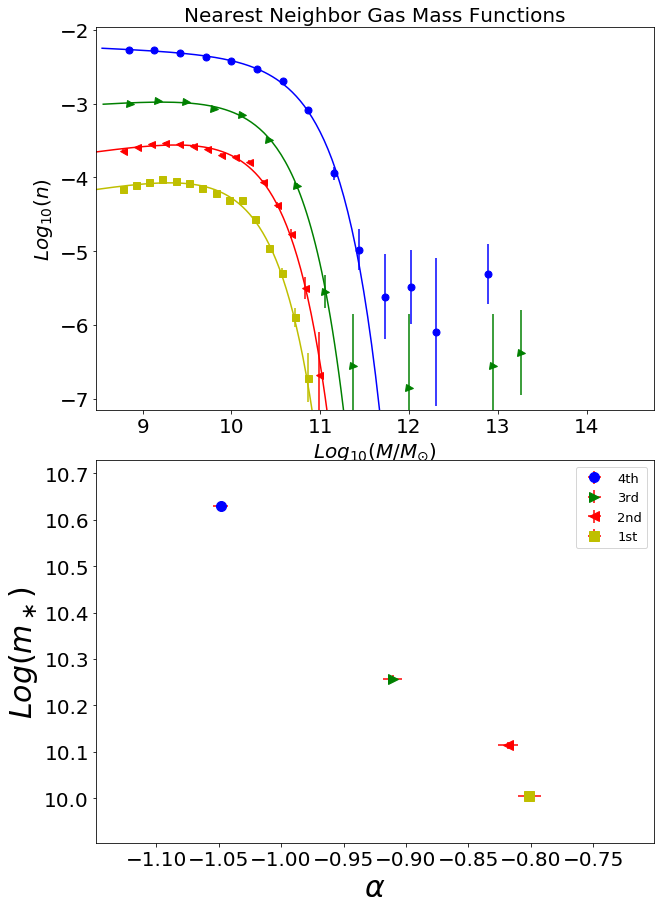

In [4]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,0,10**(8.7))
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,0,0)
#histo(15)
a = SchtrGraph2(15,"quartilesGas","Nearest Neighbor Gas Mass Functions",True,1)

In [5]:
alph,dalph,ms,dms = a
print(dms.T)

[[ 0.00789625  0.0077863 ]
 [ 0.00744557  0.0073321 ]
 [ 0.00656295  0.00644503]
 [ 0.00746267  0.00713867]]


In [6]:
#graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor Gas Knee-Mass","Quartiles_knee_mass_gas")

In [7]:
#graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor Gas Faint-end Slope","quartiles_slope_gas")

# GAS TWEB

number of haloes before: 191443
number of haloes after: 144832
16982 72021 48900 6929 144832
......................................................
0.00122927027848 [  4.32859592e-05   4.21765804e-05]
-1.02022249558 [ 0.01212464  0.01172884]
10.4056576615 [ 0.01565747  0.01527921]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:176: RuntimeWarning: divide by zero encountered in log10


......................................................
0.00320063610314 [  4.63164707e-05   4.87109852e-05]
-0.986143490392 [ 0.00529124  0.00538161]
10.3908617075 [ 0.00653311  0.00645569]
......................................................
0.00283099946307 [  4.14907760e-05   4.13923201e-05]
-0.859938397881 [ 0.00694844  0.00680533]
10.1568770987 [ 0.00649523  0.00650337]
......................................................
0.000465467435319 [  1.61817005e-05   1.61250504e-05]
-0.731592646067 [ 0.0226136   0.02220797]
9.88344440623 [ 0.01466739  0.01439899]
-1.02022249558 [ 0.01212464  0.01172884] 10.4056576615 [ 0.01565747  0.01527921] o b Cluster
-0.986143490392 [ 0.00529124  0.00538161] 10.3908617075 [ 0.00653311  0.00645569] > g Sheet
-0.859938397881 [ 0.00694844  0.00680533] 10.1568770987 [ 0.00649523  0.00650337] < r Fillament
-0.731592646067 [ 0.0226136   0.02220797] 9.88344440623 [ 0.01466739  0.01439899] s y Void


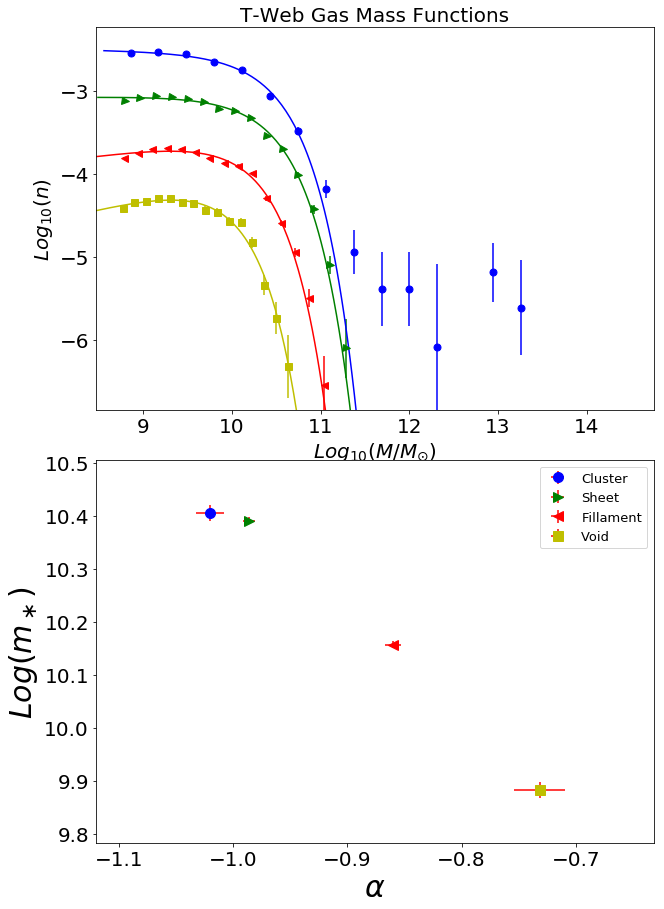

In [8]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,0,10**(8.7))
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,0,0)

a = SchtrGraph2(15,"T-Web_Gas","T-Web Gas Mass Functions",True,0)

In [9]:
#alph,dalph,ms,dms = a
#print(dms.T)

In [10]:
#graph(ms,dms,0.1,r"$m_*$","T-Web Gas Knee-Mass","Tweb_knee_mass_Gas")

In [11]:
#graph(alph,dalph,0.1,r"$\alpha_*$","T-Web Gas Faint-end Slope","TWeb_slope_gas")

# DM NEAREST NEIGHBOR

number of haloes before: 191443
number of haloes after: 115994
28999 28998 28999 28999 115995
......................................................
4.50738134135e-05 [  4.60561182e-06   4.15038513e-06]
-1.58413814221 [ 0.0053813   0.00531218]
13.3252137372 [ 0.05355935  0.05329527]
......................................................
0.000203813042276 [  2.08666902e-05   1.83144145e-05]
-1.71454300315 [ 0.01026417  0.00997255]
12.008546315 [ 0.03541694  0.03655936]
......................................................
0.000318462925988 [  2.49265753e-05   2.22677485e-05]
-1.68258171228 [ 0.01268872  0.01213991]
11.5323638388 [ 0.023432    0.02455347]
......................................................
0.000280233281397 [  2.41613395e-05   2.52523521e-05]
-1.80735162179 [ 0.01502581  0.01565041]
11.3598566629 [ 0.02726982  0.02459779]
-1.58413814221 [ 0.0053813   0.00531218] 13.3252137372 [ 0.05355935  0.05329527] o b 4th
-1.71454300315 [ 0.01026417  0.00997255] 12.008546315 [ 0.

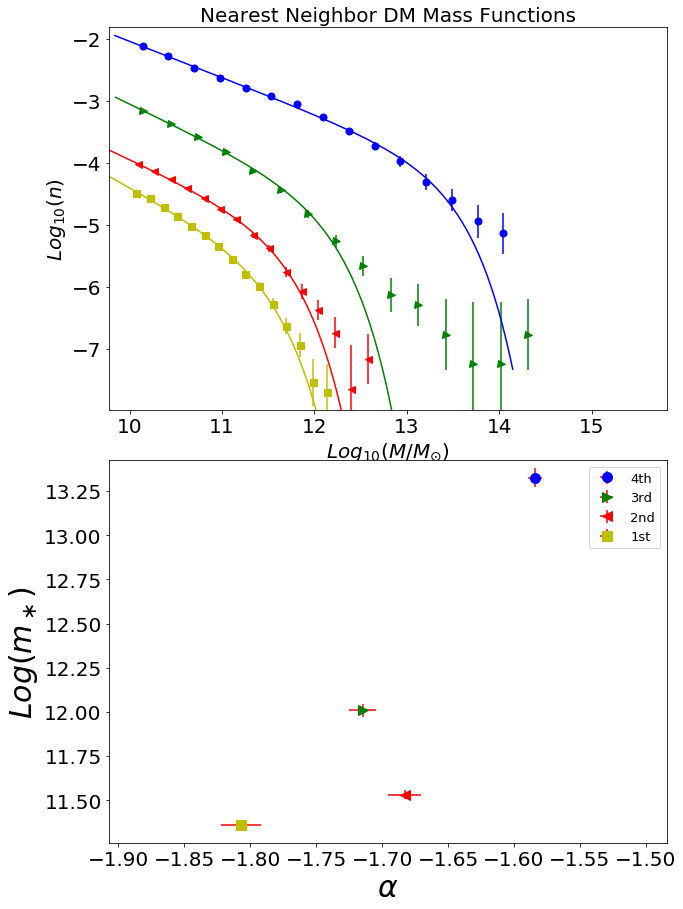

In [12]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,1,10**(10))
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,1,0)

#histo(15)
a = SchtrGraph2(15,"quartilesDM","Nearest Neighbor DM Mass Functions",True,1)

In [13]:
#alph,dalph,ms,dms = a
#print(dms.T)

In [14]:
#graph(ms,dms,0.1,r"$m_*$","Nearest Neighbor DM Knee-Mass","Quartiles_knee_mass_DM")

In [15]:
#graph(alph,dalph,0.1,r"$\alpha_*$","Nearest Neighbor DM Faint-end Slope","quartiles_slope_DM")

# DM TWEB ( Schechter functions are well adjusted to MF )

number of haloes before: 191443
number of haloes after: 115994
15867 56579 37920 5628 115994


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
2.6553862541e-09 [  2.26609851e-09   8.60941786e-08]
-1.72045229119 [ 0.00532435  0.00469347]
18.2041795695 [ 0.30725667  0.22594444]
......................................................
7.64536794313e-05 [  5.34188331e-06   4.90906322e-06]
-1.75356329916 [ 0.00480328  0.00436753]
12.7099880085 [ 0.02823734  0.02854485]
......................................................
0.000206067746624 [  1.49782516e-05   1.33931127e-05]
-1.76067318973 [ 0.00959327  0.00922955]
11.7107869706 [ 0.02175733  0.02320416]
......................................................
0.000108808735189 [  1.95326445e-05   1.71560880e-05]
-1.67904375944 [ 0.04659517  0.04474927]
11.0084711402 [ 0.04645819  0.04616081]
-1.72045229119 [ 0.00532435  0.00469347] 18.2041795695 [ 0.30725667  0.22594444] o b Cluster
-1.75356329916 [ 0.00480328  0.00436753] 12.7099880085 [ 0.02823734  0.02854485] > g Sheet
-1.76067318973 [ 0.00959327  0.00922955] 11.7107869706 [ 

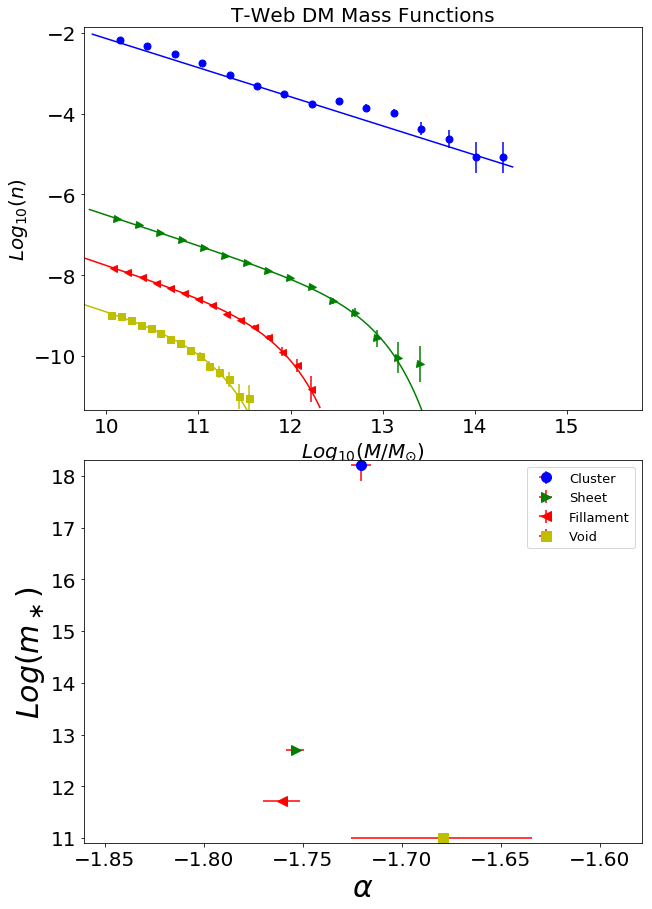

In [16]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,1,10**(10))
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,1,0)

a = SchtrGraph2(15,"T-Web_DM","T-Web DM Mass Functions",True,0)

In [17]:
#alph,dalph,ms,dms = a
#print(dms.T)

In [18]:
#graph(ms,dms,0.5,r"$m_*$","T-Web DM Knee-Mass","Tweb_knee_mass_DM")

In [19]:
#graph(alph,dalph,0.05,r"$\alpha_*$","T-Web DM Faint-end Slope","TWeb_slope_gas")

# NEAREST NEIGHBOR STELLAR MF

number of haloes before: 191443
number of haloes after: 99109
24778 24777 24777 24777 99109
......................................................
0.000351091381066 [  1.00832627e-05   1.02119972e-05]
-1.17195940518 [ 0.00346952  0.0035026 ]
11.2183641404 [ 0.02208359  0.02142327]
......................................................
0.000366329082217 [  1.44047289e-05   1.41234712e-05]
-1.23124916627 [ 0.0046838   0.00491115]
10.6738260833 [ 0.0264539   0.02612676]
......................................................
0.000404303439099 [  1.54122157e-05   1.39349769e-05]
-1.23296720642 [ 0.00571606  0.00542429]
10.2216993356 [ 0.02114284  0.02120104]
......................................................
0.000476538728482 [  1.75092223e-05   1.75078678e-05]
-1.24259738991 [ 0.00641617  0.00654489]
9.90064947368 [ 0.01955381  0.01866987]
-1.17195940518 [ 0.00346952  0.0035026 ] 11.2183641404 [ 0.02208359  0.02142327] o b 4th
-1.23124916627 [ 0.0046838   0.00491115] 10.6738260833 [ 0.

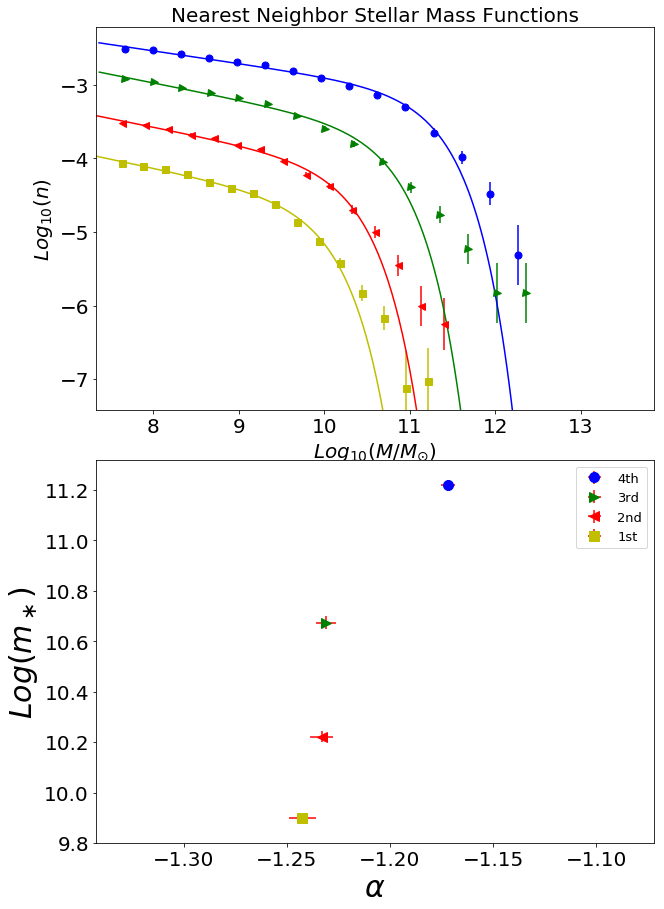

In [20]:
#loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,2,0)
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,2,10**(7.5))
#histo(15)
a = SchtrGraph2(15,"quartilesSellar","Nearest Neighbor Stellar Mass Functions",True,1)

In [21]:
#alph,dalph,ms,dms = a
#print(dms.T)

In [22]:
#graph(ms,dms,0.5,r"$m_*$","Nearest Neighbor Stellar Knee-Mass","NN_knee_mass_Stellar")

In [23]:
#graph(alph,dalph,0.05,r"$\alpha_*$","Nearest Neighbor Stellar Faint-end Slope","NN_slope_Stellar")

# TWEB STELLAR MF

number of haloes before: 191443
number of haloes after: 99109
17942 51362 26647 3158 99109
......................................................
0.000225288275002 [  1.36825274e-05   1.26931251e-05]
-1.19489967376 [ 0.00560084  0.00545088]
11.1957714084 [ 0.05204432  0.05204426]
......................................................
0.000489862278356 [  1.28450287e-05   1.27890028e-05]
-1.26652691597 [ 0.00288125  0.00292181]
10.8742377754 [ 0.01776644  0.01784932]
......................................................
0.000395359004807 [  1.37149614e-05   1.37213779e-05]
-1.24188575473 [ 0.00549826  0.0056292 ]
10.1493377115 [ 0.01927419  0.01866881]
......................................................
6.66462990154e-05 [  6.69486926e-06   6.14375099e-06]
-1.204614656 [ 0.0223857  0.02196  ]
9.52883273566 [ 0.04312858  0.04330371]
-1.19489967376 [ 0.00560084  0.00545088] 11.1957714084 [ 0.05204432  0.05204426] o b Cluster
-1.26652691597 [ 0.00288125  0.00292181] 10.8742377754 [ 0.0

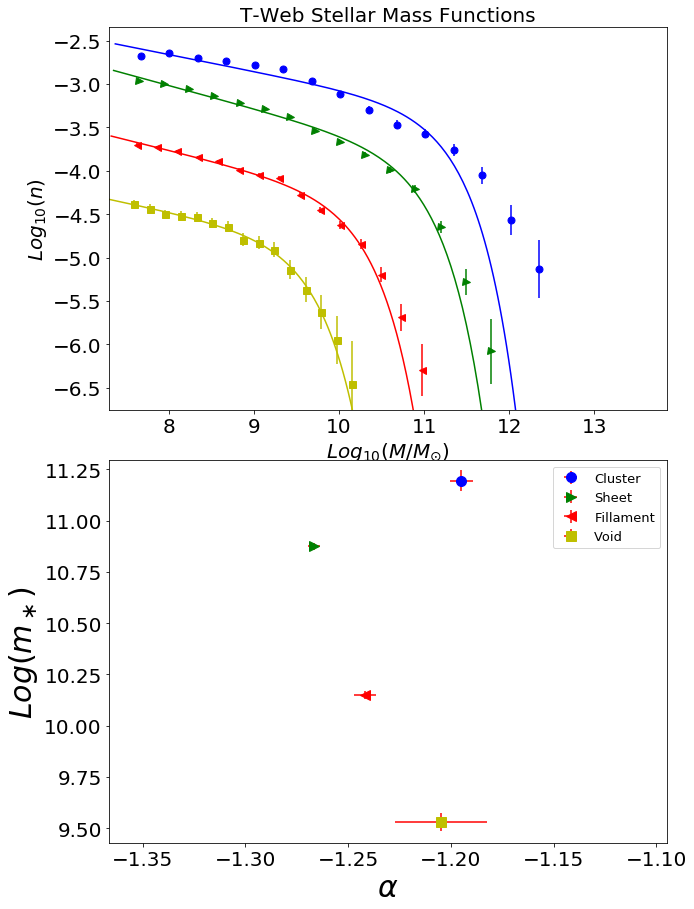

In [24]:
#loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,2,10**(0))
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,2,10**(7.5))

a = SchtrGraph2(15,"T-Web_Stellar","T-Web Stellar Mass Functions",True,0)

In [25]:
#alph,dalph,ms,dms = a
#print(dms.T)
#graph(ms,dms,0.5,r"$m_*$","T-Web Stellar Knee-Mass","Tweb_knee_mass_Stellar")
#graph(alph,dalph,0.05,r"$\alpha_*$","T-Web Stellar Faint-end Slope","Tweb_slope_Stellar")

# NEAREST NEIGHBOR BH MF

number of haloes before: 191443
number of haloes after: 5106
1277 1276 1277 1277 5107
......................................................
6.29536671967e-06 [  2.17204027e-06   1.58786437e-06]
-1.46549482968 [ 0.02896858  0.02642286]
9.47218876484 [ 0.15646507  0.16451224]
......................................................
6.14074081013e-06 [  1.43360599e-06   1.29699326e-06]
-1.4063329577 [ 0.02362566  0.02360834]
9.78289418636 [ 0.13408246  0.11692107]
......................................................
3.51321500572e-06 [  1.43508983e-06   1.23585323e-06]
-1.54151486907 [ 0.02933357  0.02924256]
9.67135992174 [ 0.23164314  0.17688375]


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
2.60483621893e-07 [  4.02096801e-07   1.81358602e-07]
-1.88414943998 [ 0.02773259  0.02566732]
10.096631933 [ 0.54039378  0.40691851]
-1.46549482968 [ 0.02896858  0.02642286] 9.47218876484 [ 0.15646507  0.16451224] o b 4th
-1.4063329577 [ 0.02362566  0.02360834] 9.78289418636 [ 0.13408246  0.11692107] > g 3rd
-1.54151486907 [ 0.02933357  0.02924256] 9.67135992174 [ 0.23164314  0.17688375] < r 2nd
-1.88414943998 [ 0.02773259  0.02566732] 10.096631933 [ 0.54039378  0.40691851] s y 1st


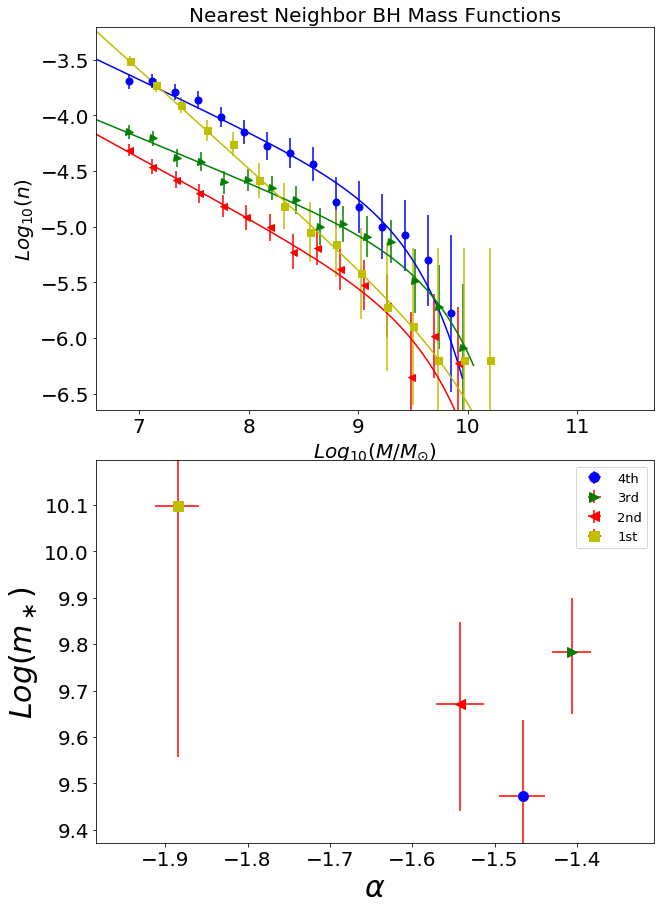

In [26]:
loadHaloes("../data/nnEnv/env1.data","../data/Masses1.csv",3.0,3,10**6.8)
#6.4
#histo(15)
a = SchtrGraph2(15,"quartilesBH","Nearest Neighbor BH Mass Functions",True,1)

In [27]:
#alph,dalph,ms,dms = a
#print(dms.T)
#graph(ms,dms,0.5,r"$m_*$","Nearest Neighbor Black Hole Knee-Mass","NN_knee_mass_BH")
#graph(alph,dalph,0.05,r"$\alpha_*$","Nearest Neighbor Black Hole Faint-end Slope","NN_slope_BH")

# TWEB BH MF

number of haloes before: 191443
number of haloes after: 5106
1828 2838 435 5 5106
......................................................
1.60875400597e-05 [  2.10418218e-06   1.90557883e-06]
-1.30672172625 [ 0.01827749  0.01801556]
9.73246668417 [ 0.06091415  0.06419696]
......................................................
1.71290682169e-05 [  3.59215079e-06   2.99362328e-06]
-1.5721011664 [ 0.02541913  0.02451806]
8.91784967459 [ 0.07610556  0.07759544]


/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/usr/local/lib/python3.5/dist-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


......................................................
4.88584787293e-06 [  8.34867944e-08   9.75880933e-08]
-1.93491830338 [  8.28349316e-05   7.69663500e-05]
7.78593202943 [ 0.00059623  0.00117085]


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:23: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:24: RuntimeWarning: divide by zero encountered in power


......................................................
-1.1852242735e-08 [  9.83593525e-08   7.38424538e-08]
-1.00881221563 [  9.91012331e-05   1.14917383e-04]
308.215556973 [ 0.00097043  0.00090829]
-1.30672172625 [ 0.01827749  0.01801556] 9.73246668417 [ 0.06091415  0.06419696] o b Cluster
-1.5721011664 [ 0.02541913  0.02451806] 8.91784967459 [ 0.07610556  0.07759544] > g 

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:168: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:193: RuntimeWarning: invalid value encountered in log10
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:194: RuntimeWarning: invalid value encountered in log10


Sheet
-1.93491830338 [  8.28349316e-05   7.69663500e-05] 7.78593202943 [ 0.00059623  0.00117085] < r Fillament
-1.00881221563 [  9.91012331e-05   1.14917383e-04] 308.215556973 [ 0.00097043  0.00090829] s y Void


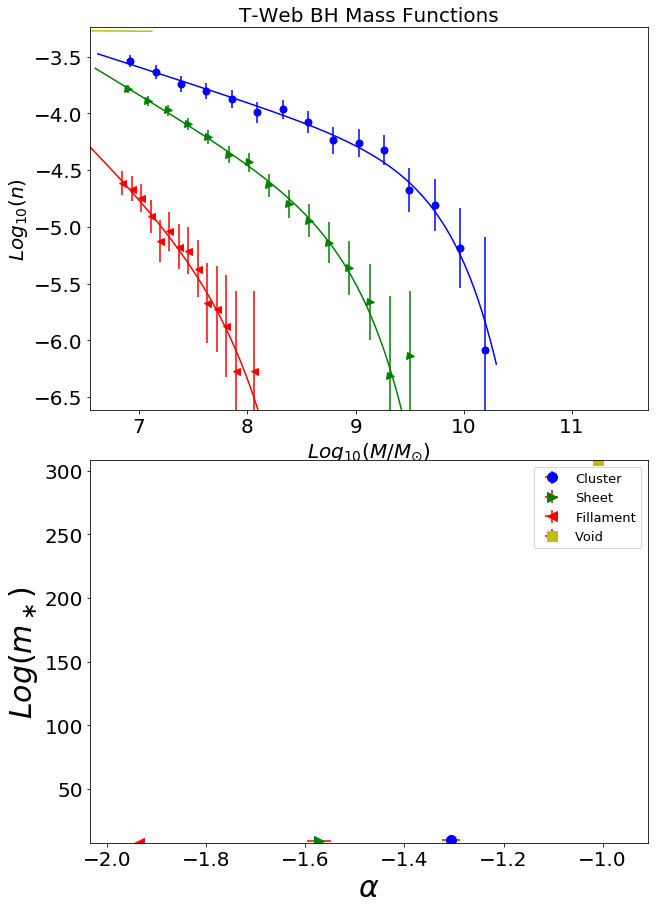

In [28]:
loadTweb("../data/twEnv/Tweb1.csv","../data/Masses1.csv",3.0,3,10**6.8)
a = SchtrGraph2(15,"T-Web_BH","T-Web BH Mass Functions",True,0)

In [29]:
#alph,dalph,ms,dms = a
#print(dms.T)
#alph[-1] = 0
#ms[-1] = 0
#graph(ms,dms,0.5,r"$m_*$","T-Web Black Hole Knee-Mass","TWeb_knee_mass_BH")
#graph(alph,dalph,0.05,r"$\alpha_*$","T-Web Black Hole Faint-end Slope","Tweb_slope_BH")